In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re
import unicodedata
import datetime
import numpy as np
import string

In [2]:
data = pd.read_csv("/Users/nigelcmc/Downloads/Final_Cleaned_Dataset_OPTIC_7.csv")

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248784 entries, 0 to 248783
Data columns (total 66 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     248784 non-null  int64  
 1   OPERATION_ID                   248784 non-null  float64
 2   LOCATION                       248784 non-null  object 
 3   ROOM                           248784 non-null  object 
 4   CASE_STATUS                    248784 non-null  object 
 5   OPERATION_TYPE                 248784 non-null  object 
 6   EMERGENCY_PRIORITY             248784 non-null  object 
 7   PLANNED_PATIENT_CALL_TIME      248784 non-null  object 
 8   PLANNED_PATIENT_FETCH_TIME     248784 non-null  object 
 9   PLANNED_RECEPTION_IN_TIME      248784 non-null  object 
 10  PLANNED_ENTER_OR_TIME          248784 non-null  object 
 11  PLANNED_ANAESTHESIA_INDUCTION  248784 non-null  object 
 12  PLANNED_SURGERY_PREP_TIME     

In [3]:
print(data.shape)
print(data.columns)

(248784, 66)
Index(['Unnamed: 0', 'OPERATION_ID', 'LOCATION', 'ROOM', 'CASE_STATUS',
       'OPERATION_TYPE', 'EMERGENCY_PRIORITY', 'PLANNED_PATIENT_CALL_TIME',
       'PLANNED_PATIENT_FETCH_TIME', 'PLANNED_RECEPTION_IN_TIME',
       'PLANNED_ENTER_OR_TIME', 'PLANNED_ANAESTHESIA_INDUCTION',
       'PLANNED_SURGERY_PREP_TIME', 'PLANNED_KNIFE_TO_SKIN_TIME',
       'PLANNED_SKIN_CLOSURE', 'PLANNED_PATIENT_REVERSAL_TIME',
       'PLANNED_EXIT_OR_TIME', 'PLANNED_EXIT_RECOVERY_TIME',
       'PLANNED_OR_CLEANUP_TIME', 'PATIENT_CALL_TIME', 'PATIENT_FETCH_TIME',
       'ACTUAL_RECEPTION_IN_TIME', 'ACTUAL_ENTER_OR_TIME',
       'ACTUAL_ANAESTHESIA_INDUCTION', 'ACTUAL_SURGERY_PREP_TIME',
       'ACTUAL_KNIFE_TO_SKIN_TIME', 'ACTUAL_SKIN_CLOSURE',
       'ACTUAL_PATIENT_REVERSAL_TIME', 'ACTUAL_EXIT_OR_TIME',
       'ACTUAL_EXIT_RECOVERY_TIME', 'ACTUAL_OR_CLEANUP_TIME', 'PATIENT_CODE',
       'SURGICAL_CODE', 'DISCIPLINE', 'SURGEON', 'ANAESTHETIST_TEAM',
       'ANAESTHETIST_MCR_NO', 'ANESTHESIA', '

In [4]:
planned_cols = [
        "PLANNED_PATIENT_CALL_TIME",
        "PLANNED_PATIENT_FETCH_TIME",
        "PLANNED_RECEPTION_IN_TIME",
        "PLANNED_ENTER_OR_TIME",
        "PLANNED_ANAESTHESIA_INDUCTION",
        "PLANNED_SURGERY_PREP_TIME",
        "PLANNED_KNIFE_TO_SKIN_TIME",
        "PLANNED_SKIN_CLOSURE",
        "PLANNED_PATIENT_REVERSAL_TIME",
        "PLANNED_EXIT_OR_TIME",
        "PLANNED_OR_CLEANUP_TIME",
        "PLANNED_EXIT_RECOVERY_TIME",        
    ]

actual_cols = [
        "PATIENT_CALL_TIME",
        "PATIENT_FETCH_TIME",
        "ACTUAL_RECEPTION_IN_TIME",
        "ACTUAL_ENTER_OR_TIME",
        "ACTUAL_ANAESTHESIA_INDUCTION",        
        "ACTUAL_SURGERY_PREP_TIME",
        "ACTUAL_KNIFE_TO_SKIN_TIME",
        "ACTUAL_SKIN_CLOSURE",
        "ACTUAL_PATIENT_REVERSAL_TIME",
        "ACTUAL_EXIT_OR_TIME",
        "ACTUAL_OR_CLEANUP_TIME",
        "ACTUAL_EXIT_RECOVERY_TIME",        
    ]

In [5]:
# Convert to datetime
for col in planned_cols + actual_cols:
    data[col] = pd.to_datetime(data[col], errors="coerce")

# Compute per-stage delay (Actual - Planned) in minutes
stage_names = [p.replace("PLANNED_", "") for p in planned_cols]  
delay_cols = []

for pcol, acol, s in zip(planned_cols, actual_cols, stage_names):
    dcol = f"DELAY_{s}"
    data[dcol] = (data[acol] - data[pcol]).dt.total_seconds() / 60.0 
    delay_cols.append(dcol)

# Clip extreme values just for display sanity
DELAY_CLIP_ABS = 600  # 10 hours
for c in delay_cols:
    data[c] = data[c].clip(lower=-DELAY_CLIP_ABS, upper=DELAY_CLIP_ABS)

# which columns exist for filtering
DISC_COL = "DISCIPLINE" if "DISCIPLINE" in data.columns else None
ROOM_COL = "ROOM" if "ROOM" in data.columns else None
OPER_COL = "OPERATION_ID" if "OPERATION_ID" in data.columns else None

In [6]:
# compute median delay per stage
median_delays = data[delay_cols].median()

# reindex with stage names for readability
median_delays.index = stage_names

print("Median delay per stage (minutes):")
print(median_delays)

Median delay per stage (minutes):
PATIENT_CALL_TIME       -47.0
PATIENT_FETCH_TIME      -37.0
RECEPTION_IN_TIME       -25.0
ENTER_OR_TIME             8.0
ANAESTHESIA_INDUCTION    -1.0
SURGERY_PREP_TIME         7.0
KNIFE_TO_SKIN_TIME       12.0
SKIN_CLOSURE              8.0
PATIENT_REVERSAL_TIME    10.0
EXIT_OR_TIME             10.0
OR_CLEANUP_TIME           8.0
EXIT_RECOVERY_TIME       79.0
dtype: float64


In [7]:
import plotly.graph_objects as go

stage_names = list(median_delays.index)
delay_values = list(median_delays.values)

# Create the vertical bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=stage_names,
    y=delay_values,
    marker_color=['#2E8B57' if delay < 0 else '#DC143C' for delay in delay_values],
    text=[f'{delay:.0f} min' for delay in delay_values],
    textposition='outside',
    textfont=dict(size=12),
    hovertemplate='<b>%{x}</b><br>Median Delay: %{y:.1f} minutes<extra></extra>'
))

# Update layout
fig.update_layout(
    title={
        'text': 'Median Delay Per Stage',
        'font': {'size': 18, 'color': 'black'},
        'x': 0.5
    },
    xaxis={
        'title': 'Stage',
        'tickangle': -45,
        'tickfont': {'size': 10}
    },
    yaxis={
        'title': 'Median Delay (minutes)',
        'zeroline': True,
        'zerolinecolor': 'black',
        'zerolinewidth': 1
    },
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=500,
    width=800,
    margin=dict(l=60, r=60, t=80, b=150),
    showlegend=False
)

# Show the plot
fig.show()

## Heatmap of Delays by Stage (Per Case)
To see where are delays concentrated

In [8]:
print(stage_names)

['PATIENT_CALL_TIME', 'PATIENT_FETCH_TIME', 'RECEPTION_IN_TIME', 'ENTER_OR_TIME', 'ANAESTHESIA_INDUCTION', 'SURGERY_PREP_TIME', 'KNIFE_TO_SKIN_TIME', 'SKIN_CLOSURE', 'PATIENT_REVERSAL_TIME', 'EXIT_OR_TIME', 'OR_CLEANUP_TIME', 'EXIT_RECOVERY_TIME']


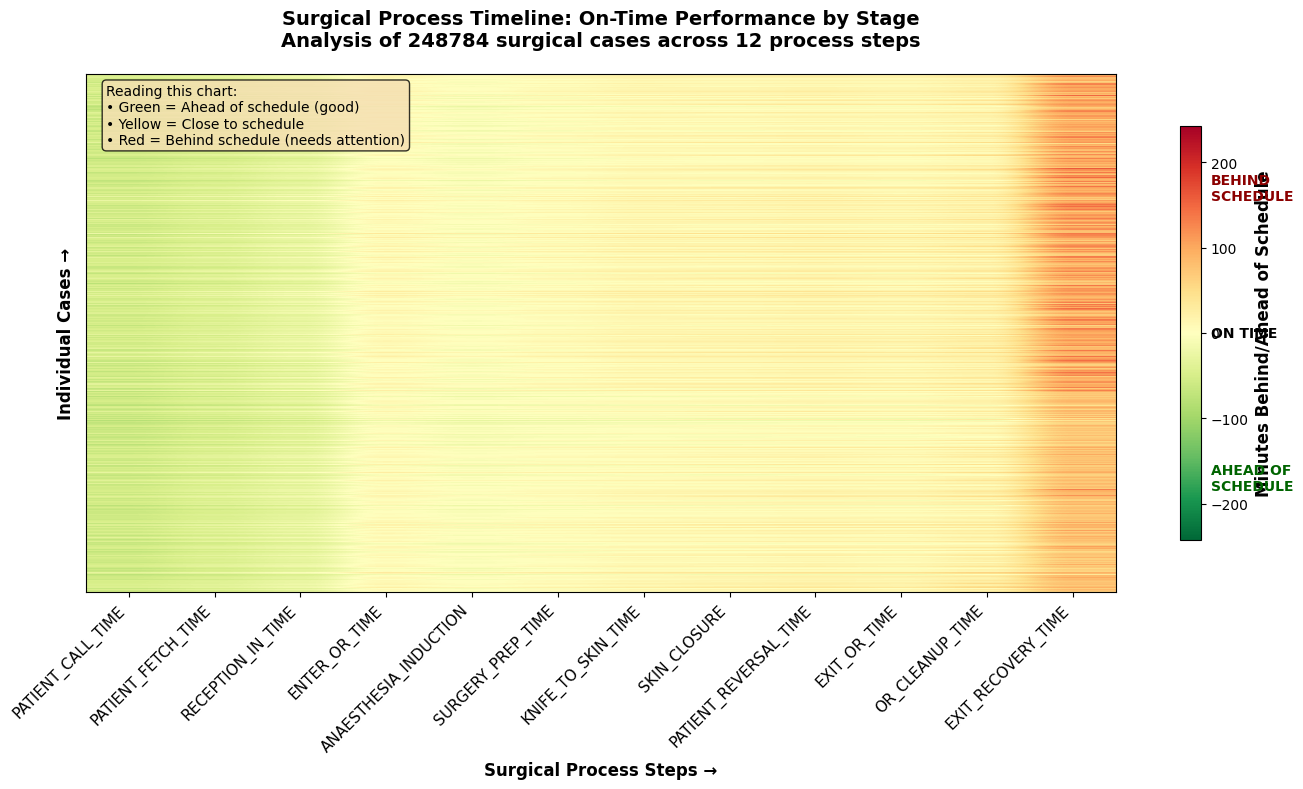

/var/folders/sr/v_3qc4c12pg68zppqbrvz8ph0000gn/T/ipykernel_42093/418685569.py:88: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



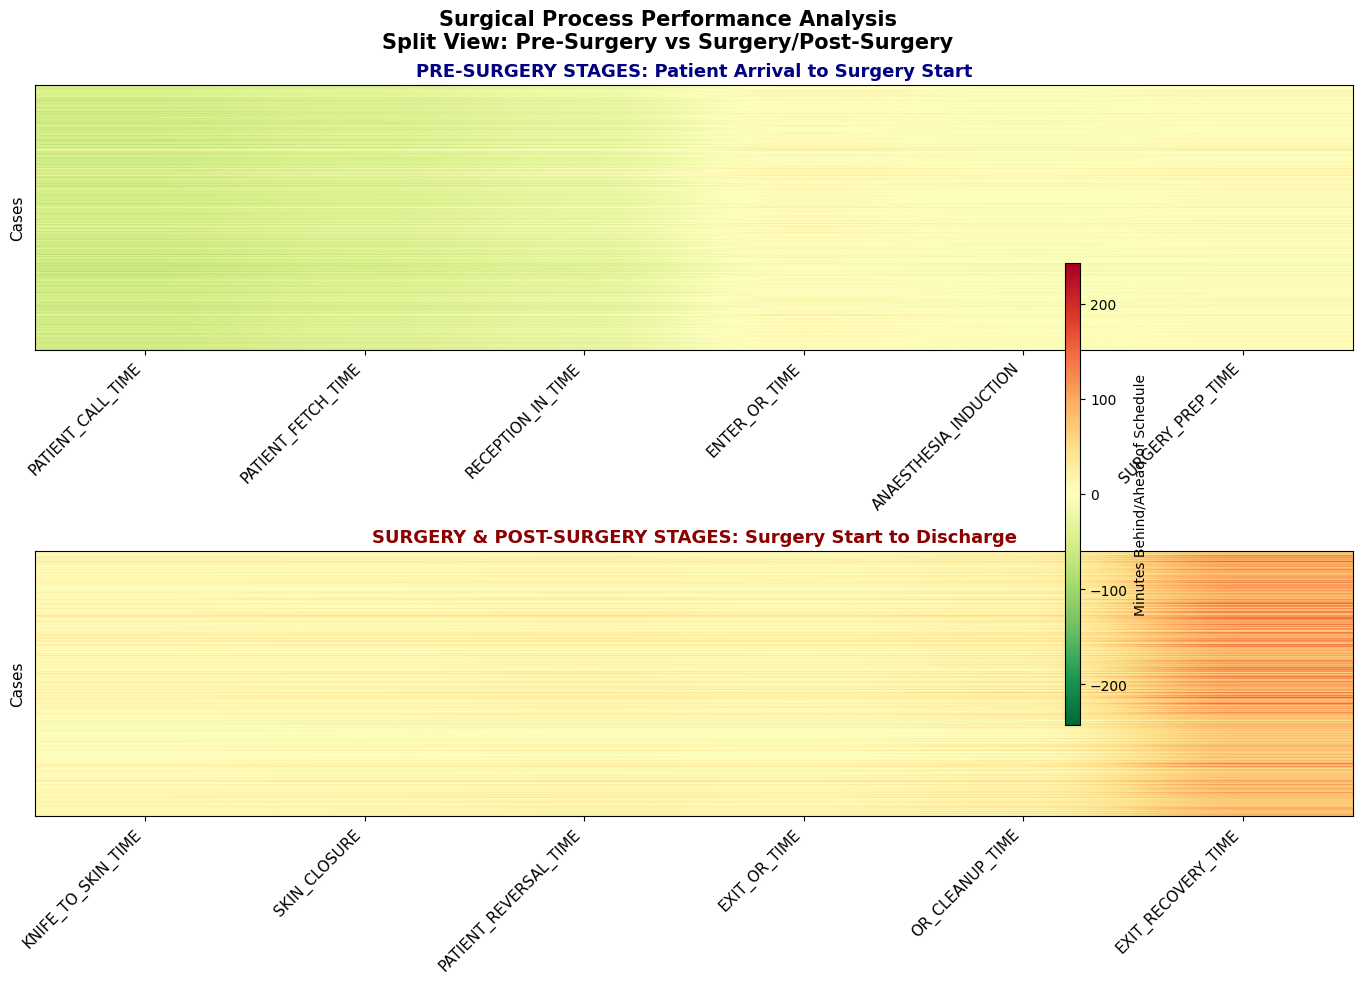


EXECUTIVE SUMMARY: SURGICAL PROCESS PERFORMANCE
         Process Step Median Delay (min)      Status  Cases Behind Schedule  Cases Ahead % On Time (±5min)
    PATIENT_CALL_TIME              -47.0 🔵 TOO EARLY                  36291       201808              4.3%
   PATIENT_FETCH_TIME              -37.0 🔵 TOO EARLY                  47043       185192              6.7%
    RECEPTION_IN_TIME              -25.0 🔵 TOO EARLY                  65061       161577              8.9%
        ENTER_OR_TIME                8.0 🟡 ATTENTION                 132870        83352             13.1%
ANAESTHESIA_INDUCTION               -1.0      🟢 GOOD                 104247       109460             14.1%
    SURGERY_PREP_TIME                7.0 🟡 ATTENTION                 128296        89758             12.4%
   KNIFE_TO_SKIN_TIME               12.0  🔴 CRITICAL                 142330        79748             10.7%
         SKIN_CLOSURE                8.0 🟡 ATTENTION                 129104        97662       

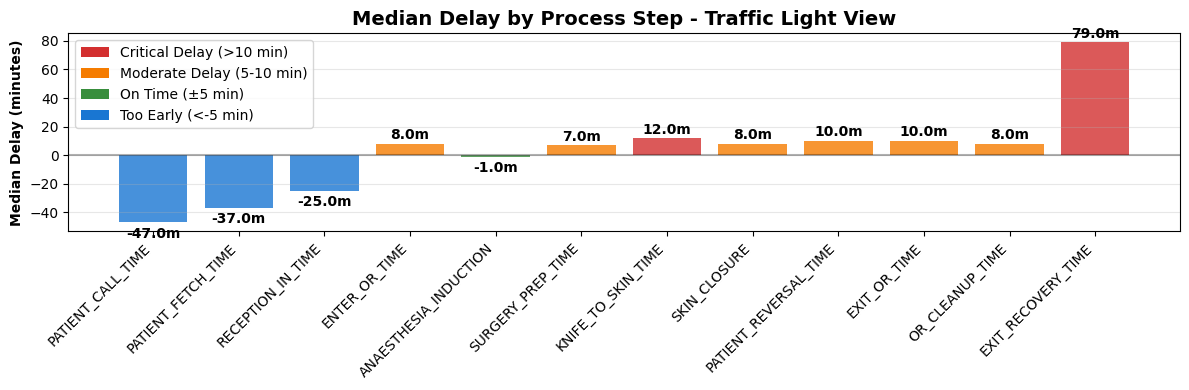

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Matrix: rows = cases, cols = stages (minutes)
delay_matrix = data[delay_cols].copy()
mat = delay_matrix.to_numpy(dtype=float)

# Set symmetric color scale using robust 95th percentile
finite_vals = mat[np.isfinite(mat)]
vmax = np.nanpercentile(np.abs(finite_vals), 95) if finite_vals.size else 1.0
vmin = -vmax

# VERSION 1: Simple interpretation with clear legend
fig, ax = plt.subplots(figsize=(14, 8))

# Use a more intuitive colormap
cmap = plt.cm.RdYlGn_r  # Red-Yellow-Green (reversed so red=bad, green=good)

im = ax.imshow(mat, aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)

# Add colorbar with clear labels
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Minutes Behind/Ahead of Schedule', fontsize=12, fontweight='bold')

# Add text annotations on colorbar
cbar.ax.text(1.5, vmax*0.7, 'BEHIND\nSCHEDULE', ha='left', va='center', 
             fontweight='bold', color='darkred', fontsize=10)
cbar.ax.text(1.5, 0, 'ON TIME', ha='left', va='center', 
             fontweight='bold', color='black', fontsize=10)
cbar.ax.text(1.5, vmin*0.7, 'AHEAD OF\nSCHEDULE', ha='left', va='center', 
             fontweight='bold', color='darkgreen', fontsize=10)

# Clear axis labels
ax.set_xticks(range(len(stage_names)))
ax.set_xticklabels(stage_names, rotation=45, ha='right', fontsize=11)
ax.set_yticks([])
ax.set_ylabel('Individual Cases →', fontsize=12, fontweight='bold')
ax.set_xlabel('Surgical Process Steps →', fontsize=12, fontweight='bold')

# Clear, descriptive title
plt.title('Surgical Process Timeline: On-Time Performance by Stage\n' + 
          f'Analysis of {mat.shape[0]} surgical cases across {mat.shape[1]} process steps',
          fontsize=14, fontweight='bold', pad=20)

# Add interpretation text
textstr = 'Reading this chart:\n• Green = Ahead of schedule (good)\n• Yellow = Close to schedule\n• Red = Behind schedule (needs attention)'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# VERSION 2: Segmented view for easier interpretation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top: Focus on early stages (pre-surgery)
early_stages = mat[:, :6]
early_labels = stage_names[:6]

im1 = ax1.imshow(early_stages, aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_xticks(range(len(early_labels)))
ax1.set_xticklabels(early_labels, rotation=45, ha='right', fontsize=11)
ax1.set_yticks([])
ax1.set_title('PRE-SURGERY STAGES: Patient Arrival to Surgery Start', 
              fontsize=13, fontweight='bold', color='navy')
ax1.set_ylabel('Cases', fontsize=11)

# Bottom: Focus on surgery and post-surgery stages
late_stages = mat[:, 6:]
late_labels = stage_names[6:]

im2 = ax2.imshow(late_stages, aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_xticks(range(len(late_labels)))
ax2.set_xticklabels(late_labels, rotation=45, ha='right', fontsize=11)
ax2.set_yticks([])
ax2.set_title('SURGERY & POST-SURGERY STAGES: Surgery Start to Discharge', 
              fontsize=13, fontweight='bold', color='darkred')
ax2.set_ylabel('Cases', fontsize=11)

# Shared colorbar
fig.colorbar(im2, ax=[ax1, ax2], shrink=0.6, aspect=30, 
             label='Minutes Behind/Ahead of Schedule')

plt.suptitle('Surgical Process Performance Analysis\nSplit View: Pre-Surgery vs Surgery/Post-Surgery', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# VERSION 3: Summary statistics table for executives
import pandas as pd

# Create summary stats
summary_stats = []
for i, stage in enumerate(stage_names):
    stage_data = mat[:, i]
    stage_data = stage_data[np.isfinite(stage_data)]
    
    if len(stage_data) > 0:
        median_delay = np.median(stage_data)
        cases_behind = np.sum(stage_data > 5)  # More than 5 min late
        cases_ahead = np.sum(stage_data < -5)  # More than 5 min early
        pct_on_time = np.sum(np.abs(stage_data) <= 5) / len(stage_data) * 100
        
        # Status based on average
        if median_delay > 10:
            status = "🔴 CRITICAL"
        elif median_delay > 5:
            status = "🟡 ATTENTION"
        elif median_delay < -10:
            status = "🔵 TOO EARLY"
        else:
            status = "🟢 GOOD"
            
        summary_stats.append({
            'Process Step': stage,
            'Median Delay (min)': f"{median_delay:.1f}",
            'Status': status,
            'Cases Behind Schedule': cases_behind,
            'Cases Ahead': cases_ahead,
            '% On Time (±5min)': f"{pct_on_time:.1f}%"
        })

summary_df = pd.DataFrame(summary_stats)

# Display the summary table
print("\n" + "="*80)
print("EXECUTIVE SUMMARY: SURGICAL PROCESS PERFORMANCE")
print("="*80)
print(summary_df.to_string(index=False))
print("\n" + "="*80)
print("KEY INSIGHTS:")
print("• 🔴 CRITICAL: Stages causing significant delays")
print("• 🟡 ATTENTION: Stages with moderate delays")  
print("• 🟢 GOOD: Stages performing well")
print("• 🔵 TOO EARLY: May indicate inefficient scheduling")
print("="*80)

# VERSION 4: Simple traffic light visualization
fig, ax = plt.subplots(figsize=(12, 4))

# Calculate average delay per stage
median_delays = [np.nanmedian(mat[:, i]) for i in range(mat.shape[1])]

# Create traffic light colors
colors = []
for delay in median_delays:
    if delay > 10:
        colors.append('#d32f2f')  # Red
    elif delay > 5:
        colors.append('#f57c00')  # Orange
    elif delay > -5:
        colors.append('#388e3c')  # Green
    else:
        colors.append('#1976d2')  # Blue (too early)

bars = ax.bar(range(len(stage_names)), median_delays, color=colors, alpha=0.8)

# Add value labels on bars
for bar, delay in zip(bars, median_delays):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -3),
            f'{delay:.1f}m', ha='center', va='bottom' if height > 0 else 'top',
            fontweight='bold', fontsize=10)

ax.set_xticks(range(len(stage_names)))
ax.set_xticklabels(stage_names, rotation=45, ha='right')
ax.set_ylabel('Median Delay (minutes)', fontweight='bold')
ax.set_title('Median Delay by Process Step - Traffic Light View', 
             fontweight='bold', fontsize=14)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#d32f2f', label='Critical Delay (>10 min)'),
    Patch(facecolor='#f57c00', label='Moderate Delay (5-10 min)'),
    Patch(facecolor='#388e3c', label='On Time (±5 min)'),
    Patch(facecolor='#1976d2', label='Too Early (<-5 min)')
]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()



## % On-Time vs Late per Stage (Stacked Bar)
Show which stage is usually on time 





In [12]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# --- CONFIG ---
ON_TIME_TOL_MIN = 5   # on-time window is ± this many minutes

# Create readable stage names
stage_readable_names = [name.replace("_TIME", "").replace("_", " ").title() for name in stage_names]

# Initialize lists to store data for each category
early_percentages = []
ontime_percentages = []
late_percentages = []

# Process each stage individually
for i, col in enumerate(delay_cols):
    # Get delay values for this stage, removing NaN
    stage_delays = data[col].dropna()
    
    if len(stage_delays) == 0:
        # No data for this stage
        early_percentages.append(0)
        ontime_percentages.append(0)
        late_percentages.append(0)
        continue
    
    # Count cases in each category
    early_count = sum(stage_delays < -ON_TIME_TOL_MIN)
    ontime_count = sum(np.abs(stage_delays) <= ON_TIME_TOL_MIN)
    late_count = sum(stage_delays > ON_TIME_TOL_MIN)
    
    total_cases = len(stage_delays)
    
    # Calculate percentages
    early_pct = early_count / total_cases
    ontime_pct = ontime_count / total_cases
    late_pct = late_count / total_cases
    
    early_percentages.append(early_pct)
    ontime_percentages.append(ontime_pct)
    late_percentages.append(late_pct)
    
    # Debug print for first few stages
    if i < 3:
        print(f"\n{stage_readable_names[i]}:")
        print(f"  Early (<-{ON_TIME_TOL_MIN}min): {early_count} ({early_pct:.1%})")
        print(f"  On-time (±{ON_TIME_TOL_MIN}min): {ontime_count} ({ontime_pct:.1%})")
        print(f"  Late (>{ON_TIME_TOL_MIN}min): {late_count} ({late_pct:.1%})")
        print(f"  Total cases: {total_cases}")

# Create the stacked bar chart using Graph Objects
fig = go.Figure()

# Add Early bars (bottom layer)
fig.add_trace(go.Bar(
    name='Early',
    x=stage_readable_names,
    y=early_percentages,
    marker_color='#1f77b4',  # Blue
    text=[f'{p:.0%}' if p > 0.02 else '' for p in early_percentages],
    textposition='inside',
    textfont=dict(color='white', size=12),
    hovertemplate='<b>%{x}</b><br>Early: %{y:.1%}<extra></extra>'
))

# Add On-Time bars (middle layer)
fig.add_trace(go.Bar(
    name='On-Time',
    x=stage_readable_names,
    y=ontime_percentages,
    marker_color='#2ca02c',  # Green
    text=[f'{p:.0%}' if p > 0.02 else '' for p in ontime_percentages],
    textposition='inside',
    textfont=dict(color='white', size=12),
    hovertemplate='<b>%{x}</b><br>On-Time: %{y:.1%}<extra></extra>'
))

# Add Late bars (top layer)
fig.add_trace(go.Bar(
    name='Late',
    x=stage_readable_names,
    y=late_percentages,
    marker_color='#d62728',  # Red
    text=[f'{p:.0%}' if p > 0.02 else '' for p in late_percentages],
    textposition='inside',
    textfont=dict(color='white', size=12),
    hovertemplate='<b>%{x}</b><br>Late: %{y:.1%}<extra></extra>'
))

# Update layout for stacked bars
fig.update_layout(
    title=f'Distribution of Timing Performance by Stage (±{ON_TIME_TOL_MIN} min tolerance)',
    xaxis_title='Process Stage',
    yaxis_title='Percentage of Cases',
    barmode='stack',
    yaxis=dict(
        tickformat='.0%',
        range=[0, 1]
    ),
    xaxis=dict(
        tickangle=-45
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    height=600,
    margin=dict(l=60, r=60, t=100, b=150)
)

fig.show()

# Print summary statistics
print(f"\n{'='*60}")
print("SUMMARY STATISTICS")
print(f"{'='*60}")

# Overall statistics
all_delays = pd.concat([data[col].dropna() for col in delay_cols])
total_observations = len(all_delays)
overall_early = sum(all_delays < -ON_TIME_TOL_MIN) / total_observations
overall_ontime = sum(np.abs(all_delays) <= ON_TIME_TOL_MIN) / total_observations
overall_late = sum(all_delays > ON_TIME_TOL_MIN) / total_observations

print(f"\nOverall Distribution:")
print(f"Early: {overall_early:.1%}")
print(f"On-Time: {overall_ontime:.1%}")
print(f"Late: {overall_late:.1%}")
print(f"Total observations: {total_observations}")

# Stage-by-stage breakdown
print(f"\nStage-by-Stage Breakdown:")
print("-" * 60)
for i, stage in enumerate(stage_readable_names):
    print(f"{stage:25} | Early: {early_percentages[i]:5.1%} | On-Time: {ontime_percentages[i]:5.1%} | Late: {late_percentages[i]:5.1%}")

# Find best and worst performers
ontime_data = [(stage_readable_names[i], ontime_percentages[i]) for i in range(len(stage_readable_names))]
ontime_data.sort(key=lambda x: x[1], reverse=True)

print(f"\nBest On-Time Performance:")
for stage, pct in ontime_data[:3]:
    print(f"• {stage}: {pct:.1%}")

print(f"\nWorst On-Time Performance:")
for stage, pct in ontime_data[-3:]:
    print(f"• {stage}: {pct:.1%}")

# Alternative visualization: Show on-time or better percentages (Early + On-Time)
fig2 = go.Figure()

# Calculate on-time or better percentages (Early + On-Time)
ontime_or_better_percentages = [early_percentages[i] + ontime_percentages[i] for i in range(len(stage_readable_names))]

fig2.add_trace(go.Scatter(
    x=stage_readable_names,
    y=ontime_or_better_percentages,
    mode='lines+markers',
    name='On-Time or Better %',
    line=dict(color='#2ca02c', width=3),
    marker=dict(size=8, color='#2ca02c'),
    text=[f'{p:.1%}' for p in ontime_or_better_percentages],
    textposition='top center',
    hovertemplate='<b>%{x}</b><br>On-Time or Better: %{y:.1%}<extra></extra>'
))

# Add target line (e.g., 80% on-time)
target_line = 0.8
fig2.add_hline(y=target_line, line_dash="dash", line_color="red", 
               annotation_text=f"Target: {target_line:.0%}")

fig2.update_layout(
    title=f'On-Time or Better Performance by Stage (±{ON_TIME_TOL_MIN} min tolerance)',
    xaxis_title='Process Stage',
    yaxis_title='Percentage On-Time or Better (Early + On-Time)',
    yaxis=dict(tickformat='.0%', range=[0, 1]),
    xaxis=dict(tickangle=-45),
    height=500,
    margin=dict(l=60, r=60, t=80, b=150)
)

print(f"\nShowing on-time or better performance (Early + On-Time)...")
fig2.show()

# Update best/worst performers to show on-time or better
ontime_or_better_data = [(stage_readable_names[i], ontime_or_better_percentages[i]) for i in range(len(stage_readable_names))]
ontime_or_better_data.sort(key=lambda x: x[1], reverse=True)

print(f"\nBest On-Time or Better Performance (Early + On-Time):")
for stage, pct in ontime_or_better_data[:3]:
    print(f"• {stage}: {pct:.1%}")

print(f"\nWorst On-Time or Better Performance (Early + On-Time):")
for stage, pct in ontime_or_better_data[-3:]:
    print(f"• {stage}: {pct:.1%}")


Patient Call:
  Early (<-5min): 201808 (81.1%)
  On-time (±5min): 10685 (4.3%)
  Late (>5min): 36291 (14.6%)
  Total cases: 248784

Patient Fetch:
  Early (<-5min): 185192 (74.4%)
  On-time (±5min): 16549 (6.7%)
  Late (>5min): 47043 (18.9%)
  Total cases: 248784

Reception In:
  Early (<-5min): 161577 (64.9%)
  On-time (±5min): 22146 (8.9%)
  Late (>5min): 65061 (26.2%)
  Total cases: 248784



SUMMARY STATISTICS

Overall Distribution:
Early: 44.9%
On-Time: 9.0%
Late: 46.1%
Total observations: 2985408

Stage-by-Stage Breakdown:
------------------------------------------------------------
Patient Call              | Early: 81.1% | On-Time:  4.3% | Late: 14.6%
Patient Fetch             | Early: 74.4% | On-Time:  6.7% | Late: 18.9%
Reception In              | Early: 64.9% | On-Time:  8.9% | Late: 26.2%
Enter Or                  | Early: 33.5% | On-Time: 13.1% | Late: 53.4%
Anaesthesia Induction     | Early: 44.0% | On-Time: 14.1% | Late: 41.9%
Surgery Prep              | Early: 36.1% | On-Time: 12.4% | Late: 51.6%
Knife To Skin             | Early: 32.1% | On-Time: 10.7% | Late: 57.2%
Skin Closure              | Early: 39.3% | On-Time:  8.9% | Late: 51.9%
Patient Reversal          | Early: 37.6% | On-Time:  8.6% | Late: 53.8%
Exit Or                   | Early: 38.2% | On-Time:  8.6% | Late: 53.3%
Or Cleanup                | Early: 40.0% | On-Time:  8.0% | Late: 52.0%
Exit Recov


Best On-Time or Better Performance (Early + On-Time):
• Patient Call: 85.4%
• Patient Fetch: 81.1%
• Reception In: 73.8%

Worst On-Time or Better Performance (Early + On-Time):
• Patient Reversal: 46.2%
• Knife To Skin: 42.8%
• Exit Recovery: 21.3%


## Timeline Dumbbell (Planned vs Actual medians)
Shows how much it deviates (gap between planned & actual) across the whole surgical journey.

## Planned vs Actual Duration Scatter Plot
Highlights systematic overruns vs underruns.

In [11]:
import numpy as np
import pandas as pd
import plotly.express as px

# --- config ---
TOL = 5          # ±5 min window
MAXPTS = 60000   # sample for speed (set None to disable)

cols = ["PLANNED_SURGERY_DURATION", "ACTUAL_SURGERY_DURATION", "DIFF_SURGERY_DURATION"]
clean = (data[cols]
         .apply(pd.to_numeric, errors="coerce")
         .dropna()
         .query("PLANNED_SURGERY_DURATION >= 0 and ACTUAL_SURGERY_DURATION >= 0")
         .copy())

if MAXPTS and len(clean) > MAXPTS:
    clean = clean.sample(n=MAXPTS, random_state=42)

def bucket(diff):
    if diff < -30:   return "Much Faster (>30 early)"
    if diff < -10:   return "Faster (10–30 early)"
    if abs(diff) <= TOL: return f"On Target (±{TOL})"
    if diff <= 30:   return "Slower (10–30 over)"
    return "Much Slower (>30 over)"

order = ["Much Faster (>30 early)", "Faster (10–30 early)", f"On Target (±{TOL})",
         "Slower (10–30 over)", "Much Slower (>30 over)"]
palette = {
    "Much Faster (>30 early)": "#1b9e77",
    "Faster (10–30 early)":    "#66c2a5",
    f"On Target (±{TOL})":     "#8c8c8c",
    "Slower (10–30 over)":     "#fdae61",
    "Much Slower (>30 over)":  "#d95f02",
}

clean["Bucket"] = clean["DIFF_SURGERY_DURATION"].apply(bucket)
clean["Bucket"] = pd.Categorical(clean["Bucket"], categories=order, ordered=True)

# Axis limits & equal scale
mn = float(min(clean["PLANNED_SURGERY_DURATION"].min(), clean["ACTUAL_SURGERY_DURATION"].min()))
mx = float(max(clean["PLANNED_SURGERY_DURATION"].max(), clean["ACTUAL_SURGERY_DURATION"].max()))
pad = 20
rng = [max(0, mn - pad), mx + pad]

# --- scatter (WebGL so points show up) ---
fig = px.scatter(
    clean,
    x="PLANNED_SURGERY_DURATION",
    y="ACTUAL_SURGERY_DURATION",
    color="Bucket",
    category_orders={"Bucket": order},
    color_discrete_map=palette,
    render_mode="webgl",           # <- important for large n
    opacity=0.6,
    labels={"PLANNED_SURGERY_DURATION":"Planned (min)",
            "ACTUAL_SURGERY_DURATION":"Actual (min)"},
    title="Planned vs Actual Surgery Duration (±5 min band)"
)

# equal axes
fig.update_xaxes(range=rng, title="Planned Surgery Duration (minutes)")
fig.update_yaxes(range=rng, title="Actual Surgery Duration (minutes)",
                 scaleanchor="x", scaleratio=1)

# --- diagonal + ±5 min bands drawn BELOW points ---
for dy, dash, name in [(0, "dash", "Actual = Planned"),
                       ( TOL, "dot",  f"+{TOL} min"),
                       (-TOL, "dot",  f"−{TOL} min")]:
    fig.add_shape(type="line", x0=rng[0], y0=rng[0]+dy, x1=rng[1], y1=rng[1]+dy,
                  line=dict(color="black", dash=dash, width=1.5 if dy==0 else 1),
                  layer="below")  # <- keeps lines under points
# optional legend entries for the bands:
fig.add_scatter(x=[None], y=[None], mode="lines", line=dict(color="black", dash="dash"), name="Actual = Planned")
fig.add_scatter(x=[None], y=[None], mode="lines", line=dict(color="gray", dash="dot"),  name=f"±{TOL} min")

# marker styling
fig.update_traces(marker=dict(size=6))

fig.update_layout(margin=dict(l=60, r=30, t=70, b=60), legend_title_text="")
fig.show()
